The objective of this notebook is :
- Convolution NN using Resnet Model
- Application of Trainer using Pytorch Lightning 
- Misclassifications using GradCam visuals
- Redesign the entire notebook based on the application of Lightning

In [4]:
%autosave 300
%autoreload 2
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [5]:
import os

os.chdir(
    "/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch"
)
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torchinfo import summary
from torchview import draw_graph
import torchvision
from src.pytorch_base.utils import imshow
import math
from torch.utils.data import DataLoader
import torchmetrics
import lightning as L
from torch.utils.data.dataset import random_split
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix
from lightning.pytorch.callbacks import (
    EarlyStopping,
    DeviceStatsMonitor,
    ModelCheckpoint,
)
from lightning.pytorch.tuner import Tuner
from src.pytorch_base.helper import set_seed, get_device

In [7]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# Setting up basic training elements
set_seed(71)
device = get_device()
print(device)
epochs = 10
learning_rate = 1e-2

Random seed set as 71
cuda


#### DATA PREP

First lets visualize the raw data by downloading and converting into tensors only

In [8]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
test = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [9]:
def get_data_characteristics(data, datatype="train"):
    """
    Get data characteristics
    Args:
    data (torch.utils.data.dataset.Dataset): Dataset object
    datatype (str): train or test
    """
    features = next(iter(data))[0]
    print(f"The data is [{datatype}]")
    print(f"Total no of datapoints: {len(data)}")
    print(f"The shape of the data: {features.shape}")
    print(f"The mean accross all channels: {features.mean(dim=(1, 2))}")
    print(f"The stdev accross all channels: {features.std(dim=(1, 2))}")
    print(f"The min pixel value: {features.min()}")
    print(f"The max pixel value: {features.max()}")
    print("\n")

In [10]:
get_data_characteristics(train, "Train Dataset")
get_data_characteristics(test, "Test Dataset")

The data is [Train Dataset]
Total no of datapoints: 50000
The shape of the data: torch.Size([3, 32, 32])
The mean accross all channels: tensor([0.5537, 0.4122, 0.2511])
The stdev accross all channels: tensor([0.1595, 0.1665, 0.1603])
The min pixel value: 0.0
The max pixel value: 1.0


The data is [Test Dataset]
Total no of datapoints: 10000
The shape of the data: torch.Size([3, 32, 32])
The mean accross all channels: tensor([0.4315, 0.4344, 0.4093])
The stdev accross all channels: tensor([0.2062, 0.1429, 0.1927])
The min pixel value: 0.05098039284348488
The max pixel value: 1.0




In [11]:
def show_rawdata(data_set, number_of_samples):

    if number_of_samples % 2 == 0:
        batch_data = []
        batch_label = []
        for count, item in enumerate(data_set):
            if not count < number_of_samples:
                break
            batch_data.append(item[0])
            batch_label.append(item[1])

        batch_data = torch.stack(batch_data, dim=0).numpy()

        fix, axs = plt.subplots(
            ncols=number_of_samples // 2, nrows=2, sharex=True, sharey=True
        )
        k, i = 0, 0
        for img, label in list(zip(batch_data, batch_label)):
            if i != 0 and i % (number_of_samples // 2) == 0:
                k += 1
                i = 0
            axs[k, i].set_title(classes[label])
            axs[k, i].imshow(
                np.transpose(img.squeeze(), (1, 2, 0)),
                interpolation="nearest",
            )
            axs[k, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            i += 1

        plt.show()
    else:
        raise Exception("The number of samples should be divisible by 2")

<Figure size 1800x1080 with 0 Axes>

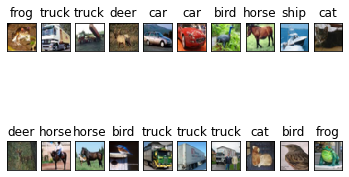

In [12]:
plt.figure(figsize=(25, 15))
show_rawdata(train, 20)

Next we will create an custom dataset for Abulmenation package by subclassing datasets.CIFAR10

In [13]:
# transform for the dataset using Compose from albumentations
import albumentations as alb
from albumentations.pytorch import ToTensorV2

mean = (0.49139968, 0.48215827, 0.44653124)
std = (0.24703233, 0.24348505, 0.26158768)


def data_augmentations():
    """Data Augmentations for the CIFAR10 dataset"""
    train_transforms = alb.Compose(
        [
            alb.PadIfNeeded(min_height=36, min_width=36, always_apply=True),
            alb.RandomCrop(height=32, width=32, always_apply=True),
            alb.HorizontalFlip(),
            alb.CoarseDropout(
                max_holes=1,
                max_height=16,
                max_width=16,
                min_holes=1,
                min_height=16,
                min_width=16,
                fill_value=tuple(x * 255 for x in mean),
                mask_fill_value=None,
            ),
            alb.Normalize(mean=mean, std=std),
            ToTensorV2(),
        ]
    )

    test_transforms = alb.Compose(
        [
            alb.Normalize(mean=mean, std=std),
            ToTensorV2(),
        ]
    )
    return train_transforms, test_transforms

In [14]:
# train_transforms, test_transforms = data_augmentations()

In [15]:
class AlbumentationsCifar10(datasets.CIFAR10):
    def __init__(
        self,
        root: str,
        train: bool = True,
        transform=None,
        target_transform=None,
        download: bool = False,
    ):
        super(AlbumentationsCifar10, self).__init__(
            root,
            train=train,
            transform=transform,
            target_transform=target_transform,
            download=download,
        )
        self.transform = transform

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        if self.transform is not None:
            img = self.transform(image=img)["image"]
        return img, target

In [16]:
# train_dataset = AlbumentationsCifar10(
#     root="./data", train=True, download=False, transform=train_transforms
# )

In [17]:
# get_data_characteristics(train_dataset, "Train Dataset")

In [18]:
# plt.figure(figsize=(25, 15))
# show_raw_data(train_dataset, 20)

In [19]:
class Cifar10DataModule(L.LightningDataModule):
    def __init__(
        self,
        data_dir="./data",
        batch_size=128,
        num_workers=0,
    ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_transforms, self.test_transforms = data_augmentations()

    def prepare_data(self) -> None:
        AlbumentationsCifar10(root=self.data_dir, train=True, download=True)
        AlbumentationsCifar10(root=self.data_dir, train=False, download=True)

    def setup(self, stage: str):
        if stage == "train" or stage == "fit":
            mnist_full = AlbumentationsCifar10(
                root=self.data_dir, train=True, transform=self.train_transforms
            )
            self.mnist_train, self.mnist_val = random_split(
                mnist_full, [0.7, 0.3], generator=torch.Generator().manual_seed(71)
            )

        elif stage == "test" or stage == "predict":
            self.mnist_test = AlbumentationsCifar10(
                root=self.data_dir, train=False, transform=self.test_transforms
            )

    def train_dataloader(self):
        return DataLoader(
            self.mnist_train,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=False,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(
            self.mnist_val,
            batch_size=self.batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        return DataLoader(
            self.mnist_test,
            batch_size=self.batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=self.num_workers,
        )

    def predict_dataloader(self):
        return DataLoader(
            self.mnist_test,
            batch_size=self.batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=self.num_workers,
        )

    def teardown(self, stage: str):
        # Used to clean-up when the run is finished
        ...

In [20]:
dm = Cifar10DataModule()
dm.prepare_data()

# splits/transforms
dm.setup(stage="fit")

# use data
for batch in dm.train_dataloader():
    x, y = batch
    print(x.shape)
    print(y.shape)
    print(x.mean())
    print(x.std())
    break

for batch in dm.val_dataloader():
    x, y = batch
    print(x.shape)
    print(y.shape)
    print(x.mean())
    print(x.std())
    break

dm.teardown(stage="fit")

Files already downloaded and verified
Files already downloaded and verified
torch.Size([128, 3, 32, 32])
torch.Size([128])
tensor(-0.0388)
tensor(0.9474)
torch.Size([128, 3, 32, 32])
torch.Size([128])
tensor(-0.0032)
tensor(0.9450)


In [21]:
# # get dataloader for data batching
# dataloader_args = (
#     dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True)
#     if device.type == "cuda"
#     else dict(shuffle=True, batch_size=128)
# )

# # get train and test transformations
# train_transforms, test_transforms = data_augmentations()

# # batch loading
# train_dataset, train_loader, test_dataset, test_loader = get_data_loader(
#     train, test, train_transforms, test_transforms, dataloader_args
# )

In [22]:
# for images, labels in train_loader:
#     print(images.shape)
#     print(labels.shape)
#     print(images.mean())
#     print(images.std())
#     break

In [23]:
def show_batchdata(batch, samples):
    if samples % 10 == 0:
        plt.figure(figsize=(25, 15))
        imshow(torchvision.utils.make_grid(batch[:samples], nrow=(samples // 5)))
        plt.show()
    else:
        raise Exception("The number of samples should be divisible by 5")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


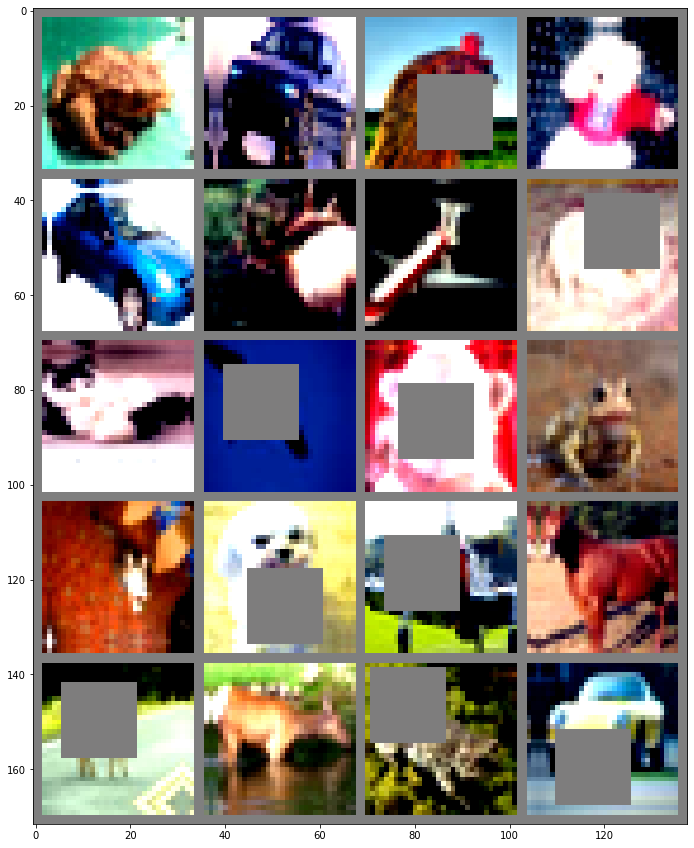

In [24]:
show_batchdata(x,20)

#### MODEL BUILDING

In [25]:
from src.paper_nets.resnet import ResNetX

In [26]:
model_parameters = {}
model_parameters["resnet18"] = ([64, 128, 256, 512], [2, 2, 2, 2], 1, False)
model_parameters["resnet34"] = ([64, 128, 256, 512], [3, 4, 6, 3], 1, False)
model_parameters["resnet50"] = ([64, 128, 256, 512], [3, 4, 6, 3], 4, True)
model_parameters["resnet101"] = ([64, 128, 256, 512], [3, 4, 23, 3], 4, True)
model_parameters["resnet152"] = ([64, 128, 256, 512], [3, 8, 36, 3], 4, True)

In [27]:
resnet_model = ResNetX(
    resnet_variant=model_parameters["resnet34"], img_channels=3, num_classes=10
).to(device)
print(resnet_model)

ResNetX(
  (prep_layer): ResnetPrepBlock(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pooling): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (layer1): Sequential(
    (0): ResnetBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ResnetBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [28]:
summary(resnet_model, (1,3, 32,32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNetX                                  [1, 10]                   --
├─ResnetPrepBlock: 1-1                   [1, 64, 8, 8]             --
│    └─Conv2d: 2-1                       [1, 64, 16, 16]           9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 16, 16]           128
│    └─ReLU: 2-3                         [1, 64, 16, 16]           --
│    └─MaxPool2d: 2-4                    [1, 64, 8, 8]             --
├─Sequential: 1-2                        [1, 64, 8, 8]             --
│    └─ResnetBasicBlock: 2-5             [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-1                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 8, 8]             128
│    │    └─ReLU: 3-3                    [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-4                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 8, 8]             128
│

In [35]:
class Cifar10ModelLightning(L.LightningModule):
    def __init__(self, model, learning_rate):
        super(Cifar10ModelLightning, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.criterion = torch.nn.CrossEntropyLoss()
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.save_hyperparameters(ignore=["model"])

    def forward(self, x: torch.Tensor):
        """
        Forward computation of the model
        """
        return self.model(x)

    def _shared_step(self, batch):
        """
        Shared step for training and validation
        """
        features, label = batch
        logits = self(features)
        loss = self.criterion(logits, label)
        predictions = torch.argmax(logits, dim=1)
        return label, loss, predictions

    def training_step(self, batch, batch_idx):
        """
        Training Step loss and metric calculation
        """

        label, loss, predictions = self._shared_step(batch)
        self.log(name="train_loss", value=loss, prog_bar=True)
        # metric calculation
        self.train_acc(predictions, label)
        self.log(
            name="train_acc",
            value=self.train_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation Step loss and metric calculation
        """

        label, loss, predictions = self._shared_step(batch)
        self.log(name="val_loss", value=loss, prog_bar=True)
        # metric calculation
        self.test_acc(predictions, label)
        self.log(
            name="val_acc",
            value=self.test_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

    def test_step(self, batch, batch_idx):
        """
        Test step metric calculation
        """
        label, loss, predictions = self._shared_step(batch)
        # metric calculation
        self.test_acc(predictions, label)
        self.log(
            name="test_acc",
            value=self.test_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

    def configure_optimizers(
        self,
    ):
        """
        Optimizer config
        """
        optimizer = torch.optim.Adam(
            self.parameters(), lr=learning_rate, weight_decay=1e-4
        )
        return {
            "optimizer": optimizer,
        }

Basic Model Testing

In [36]:
# base pytorch model
resnet_model = ResNetX(
    resnet_variant=model_parameters["resnet34"], img_channels=3, num_classes=10
).to(device)

# lightning wrapped model
lightning_resnet = Cifar10ModelLightning(
    model=resnet_model,
    learning_rate=learning_rate,
)

# lightning dataloder
dm = Cifar10DataModule(num_workers=5)

In [37]:
# setting up the trainer module
trainer = L.Trainer(
    max_epochs=epochs,
    accelerator="auto",
    devices="auto",
    enable_progress_bar=True,
    enable_model_summary=True,
    logger=CSVLogger(save_dir="./logs", name="Mnist_exp"),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [29]:
# fitting the model with custom datamodule
trainer.fit(model=lightning_resnet, datamodule=dm)

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNetX            | 21.3 M
1 | criterion | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.159    Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


In [30]:
val_acc = trainer.validate(datamodule=dm)[0]["val_acc"]
test_acc = trainer.test(datamodule=dm)[0]["test_acc"]
print(f" | Val Acc {val_acc*100:.2f}%" f" | Test Acc {test_acc*100:.2f}%")

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at ./logs/Mnist_exp/version_50/checkpoints/epoch=9-step=2740.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./logs/Mnist_exp/version_50/checkpoints/epoch=9-step=2740.ckpt
/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |                                                                                                 …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.5820000171661377     │
│         val_loss          │     1.204719066619873     │
└───────────────────────────┴───────────────────────────┘

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at ./logs/Mnist_exp/version_50/checkpoints/epoch=9-step=2740.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./logs/Mnist_exp/version_50/checkpoints/epoch=9-step=2740.ckpt


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6420000195503235     │
└───────────────────────────┴───────────────────────────┘

 | Val Acc 58.20% | Test Acc 64.20%


In [29]:
def loss_metric_plot(trainer):
    # Plotting the metrics
    metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

    aggreg_metrics = []
    agg_col = "epoch"
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggreg_metrics.append(agg)
    df_metrics = pd.DataFrame(aggreg_metrics)
    
    df_metrics[["train_loss", "val_loss"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
    )
    df_metrics[["train_acc", "val_acc"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
    )
    plt.show()

In [32]:
loss_metric_plot(trainer)

Application of model ModelCheckpoint    

In [38]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=True, mode="min")
device_monitor = DeviceStatsMonitor()
model_checkpoint = ModelCheckpoint(
    dirpath="./models",
    monitor="val_loss",
    mode="min",
    verbose=True,
    save_top_k=1,
)

In [39]:
# base pytorch model
resnet_model = ResNetX(
    resnet_variant=model_parameters["resnet34"], img_channels=3, num_classes=10
).to(device)

# lightning wrapped model
lightning_resnet = Cifar10ModelLightning(
    model=resnet_model,
    learning_rate=learning_rate,
)

# lightning dataloder
dm = Cifar10DataModule(num_workers=5)

In [40]:
# setting up the trainer module
trainer = L.Trainer(
    max_epochs=epochs,
    accelerator="auto",
    devices="auto",
    enable_progress_bar=True,
    enable_model_summary=True,
    logger=CSVLogger(save_dir="./logs", name="Mnist_exp"),
    callbacks=[early_stopping, device_monitor, model_checkpoint],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [36]:
# fitting the model with custom datamodule
trainer.fit(model=lightning_resnet, datamodule=dm)

Files already downloaded and verified
Files already downloaded and verified


/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNetX            | 21.3 M
1 | criterion | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.159    Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |                                                                                                   …

/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |                                                                                                 …

Metric val_loss improved. New best score: 2.859
Epoch 0, global step 274: 'val_loss' reached 2.85897 (best 2.85897), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=0-step=274.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 1.270 >= min_delta = 0.0. New best score: 1.588
Epoch 1, global step 548: 'val_loss' reached 1.58850 (best 1.58850), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=1-step=548-v1.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 1.546
Epoch 2, global step 822: 'val_loss' reached 1.54602 (best 1.54602), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=2-step=822.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.143 >= min_delta = 0.0. New best score: 1.403
Epoch 3, global step 1096: 'val_loss' reached 1.40308 (best 1.40308), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=3-step=1096.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.388
Epoch 4, global step 1370: 'val_loss' reached 1.38820 (best 1.38820), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=4-step=1370.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.108 >= min_delta = 0.0. New best score: 1.280
Epoch 5, global step 1644: 'val_loss' reached 1.27976 (best 1.27976), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=5-step=1644.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.237
Epoch 6, global step 1918: 'val_loss' reached 1.23671 (best 1.23671), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=6-step=1918.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.202
Epoch 7, global step 2192: 'val_loss' reached 1.20207 (best 1.20207), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=7-step=2192-v1.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.179
Epoch 8, global step 2466: 'val_loss' reached 1.17879 (best 1.17879), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=8-step=2466-v2.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 1.137
Epoch 9, global step 2740: 'val_loss' reached 1.13710 (best 1.13710), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=9-step=2740-v5.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


In [37]:
val_acc = trainer.validate(datamodule=dm, ckpt_path="best")[0]["val_acc"]
test_acc = trainer.test(datamodule=dm, ckpt_path="best")[0]["test_acc"]
print(
    f" | Val Acc {val_acc*100:.2f}%"
    f" | Test Acc {test_acc*100:.2f}%"
)

Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=9-step=2740-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=9-step=2740-v5.ckpt
/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |                                                                                                 …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.5960000157356262     │
│         val_loss          │    1.1392168998718262     │
└───────────────────────────┴───────────────────────────┘

Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=9-step=2740-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=9-step=2740-v5.ckpt


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6525999903678894     │
└───────────────────────────┴───────────────────────────┘

 | Val Acc 59.60% | Test Acc 65.26%


Application of LR finder to get the best LR and then schedule it using 2 types of scheduler

In [41]:
# base pytorch model
resnet_model = ResNetX(
    resnet_variant=model_parameters["resnet34"], img_channels=3, num_classes=10
).to(device)

# lightning wrapped model
lightning_resnet = Cifar10ModelLightning(
    model=resnet_model,
    learning_rate=learning_rate,
)

# lightning dataloder
dm = Cifar10DataModule(num_workers=5)

In [42]:
# setting up the trainer module
trainer = L.Trainer(
    max_epochs=epochs,
    accelerator="auto",
    devices="auto",
    enable_progress_bar=True,
    enable_model_summary=True,
    logger=CSVLogger(save_dir="./logs", name="Mnist_exp"),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [43]:
tuner = Tuner(trainer=trainer)

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finding best initial lr:   0%|          | 0/150 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=150` reached.
Learning rate set to 0.0008844365191385997
Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/.lr_find_f150a068-b158-4078-9ae6-f32ae5084f24.ckpt
Restored all states from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/.lr_find_f150a068-b158-4078-9ae6-f32ae5084f24.ckpt


0.0008844365191385997


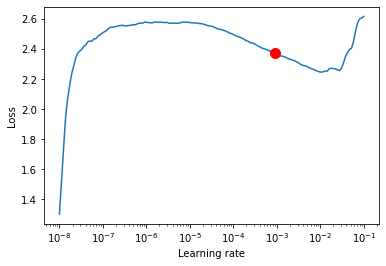

In [44]:
lr_finder = tuner.lr_find(lightning_resnet, datamodule=dm, num_training=150, max_lr=0.1)
fig = lr_finder.plot(suggest=True)
suggested_lr = lr_finder.suggestion()
print(suggested_lr)

In [45]:
# update hparams of the model
lightning_resnet.learning_rate = suggested_lr

In [43]:
trainer.fit(model=lightning_resnet, datamodule=dm)

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNetX            | 21.3 M
1 | criterion | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.159    Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


In [44]:
val_acc = trainer.validate(datamodule=dm)[0]["val_acc"]
test_acc = trainer.test(datamodule=dm,)[0]["test_acc"]
print(
    f" | Val Acc {val_acc*100:.2f}%"
    f" | Test Acc {test_acc*100:.2f}%"
)

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at ./logs/Mnist_exp/version_52/checkpoints/epoch=9-step=2740.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./logs/Mnist_exp/version_52/checkpoints/epoch=9-step=2740.ckpt


Validation: |                                                                                                 …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.5646666884422302     │
│         val_loss          │    1.2485295534133911     │
└───────────────────────────┴───────────────────────────┘

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at ./logs/Mnist_exp/version_52/checkpoints/epoch=9-step=2740.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./logs/Mnist_exp/version_52/checkpoints/epoch=9-step=2740.ckpt


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6309000253677368     │
└───────────────────────────┴───────────────────────────┘

 | Val Acc 56.47% | Test Acc 63.09%


Application of LR Scheduler
- Exponential
- OneCycleLR
- CosineAnnealingLR

In [46]:
class Cifar10ModelLightning(L.LightningModule):
    def __init__(self, model, learning_rate):
        super(Cifar10ModelLightning, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.criterion = torch.nn.CrossEntropyLoss()
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.save_hyperparameters(ignore=["model"])

    def forward(self, x: torch.Tensor):
        """
        Forward computation of the model
        """
        return self.model(x)

    def _shared_step(self, batch):
        """
        Shared step for training and validation
        """
        features, label = batch
        logits = self(features)
        loss = self.criterion(logits, label)
        predictions = torch.argmax(logits, dim=1)
        return label, loss, predictions

    def training_step(self, batch, batch_idx):
        """
        Training Step loss and metric calculation
        """

        label, loss, predictions = self._shared_step(batch)
        self.log(name="train_loss", value=loss, prog_bar=True)
        # metric calculation
        self.train_acc(predictions, label)
        self.log(
            name="train_acc",
            value=self.train_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation Step loss and metric calculation
        """

        label, loss, predictions = self._shared_step(batch)
        self.log(name="val_loss", value=loss, prog_bar=True)
        # metric calculation
        self.test_acc(predictions, label)
        self.log(
            name="val_acc",
            value=self.test_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

    def test_step(self, batch, batch_idx):
        """
        Test step metric calculation
        """
        label, loss, predictions = self._shared_step(batch)
        # metric calculation
        self.test_acc(predictions, label)
        self.log(
            name="test_acc",
            value=self.test_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

    def configure_optimizers(
        self,
    ):
        """
        Optimizer config
        """
        optimizer = torch.optim.Adam(
            self.parameters(), lr=learning_rate, weight_decay=1e-4
        )
        scheduler = torch.optim.lr_scheduler.ExponentialLR(
            optimizer=optimizer, gamma=0.9, verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",  # step means "batch" here, default: epoch   # New!
                "frequency": 1,  # default
            },
        }

In [47]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=True, mode="min")
device_monitor = DeviceStatsMonitor()
model_checkpoint = ModelCheckpoint(
    dirpath="./models",
    monitor="val_loss",
    mode="min",
    verbose=True,
    save_top_k=1,
)

In [48]:
# base pytorch model
resnet_model = ResNetX(
    resnet_variant=model_parameters["resnet34"], img_channels=3, num_classes=10
).to(device)

# lightning wrapped model
lightning_resnet = Cifar10ModelLightning(
    model=resnet_model,
    learning_rate=suggested_lr,
)

# lightning dataloder
dm = Cifar10DataModule(num_workers=5)
# setting up the trainer module
trainer = L.Trainer(
    max_epochs=(epochs),
    accelerator="auto",
    devices="auto",
    enable_progress_bar=True,
    enable_model_summary=True,
    logger=CSVLogger(save_dir="./logs", name="Mnist_exp"),
    callbacks=[early_stopping, device_monitor, model_checkpoint],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [48]:
# fitting the model on training and test on validation data
trainer.fit(model=lightning_resnet, datamodule=dm)

Files already downloaded and verified
Files already downloaded and verified


/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/azureuser/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNetX            | 21.3 M
1 | criterion | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Metric val_loss improved. New best score: 1.931
Epoch 0, global step 274: 'val_loss' reached 1.93142 (best 1.93142), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=0-step=274.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.248 >= min_delta = 0.0. New best score: 1.683
Epoch 1, global step 548: 'val_loss' reached 1.68299 (best 1.68299), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=1-step=548-v1.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.097 >= min_delta = 0.0. New best score: 1.586
Epoch 2, global step 822: 'val_loss' reached 1.58586 (best 1.58586), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=2-step=822.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.237 >= min_delta = 0.0. New best score: 1.349
Epoch 3, global step 1096: 'val_loss' reached 1.34874 (best 1.34874), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=3-step=1096.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 1.289
Epoch 4, global step 1370: 'val_loss' reached 1.28932 (best 1.28932), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=4-step=1370.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 1.231
Epoch 5, global step 1644: 'val_loss' reached 1.23145 (best 1.23145), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=5-step=1644.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.204
Epoch 6, global step 1918: 'val_loss' reached 1.20397 (best 1.20397), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=6-step=1918.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.089 >= min_delta = 0.0. New best score: 1.115
Epoch 7, global step 2192: 'val_loss' reached 1.11530 (best 1.11530), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=7-step=2192-v1.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.086 >= min_delta = 0.0. New best score: 1.030
Epoch 8, global step 2466: 'val_loss' reached 1.02969 (best 1.02969), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=8-step=2466-v2.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.997
Epoch 9, global step 2740: 'val_loss' reached 0.99685 (best 0.99685), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=9-step=2740-v6.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


In [49]:
# testing the metrics
val_acc = trainer.validate(datamodule=dm, ckpt_path="best")[0]["val_acc"]
test_acc = trainer.test(datamodule=dm, ckpt_path="best")[0]["test_acc"]
print(f" | Val Acc {val_acc*100:.2f}%" f" | Test Acc {test_acc*100:.2f}%")

Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=9-step=2740-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=9-step=2740-v6.ckpt


Validation: |                                                                                                 …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.647266685962677     │
│         val_loss          │    0.9956516027450562     │
└───────────────────────────┴───────────────────────────┘

Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=9-step=2740-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=9-step=2740-v6.ckpt


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7049999833106995     │
└───────────────────────────┴───────────────────────────┘

 | Val Acc 64.73% | Test Acc 70.50%


One Cycle Lr

In [49]:
class Cifar10ModelLightning(L.LightningModule):
    def __init__(self, model, learning_rate, lr_steps):
        super(Cifar10ModelLightning, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.criterion = torch.nn.CrossEntropyLoss()
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.save_hyperparameters(ignore=["model"])
        self.lr_steps = lr_steps

    def forward(self, x: torch.Tensor):
        """
        Forward computation of the model
        """
        return self.model(x)

    def _shared_step(self, batch):
        """
        Shared step for training and validation
        """
        features, label = batch
        logits = self(features)
        loss = self.criterion(logits, label)
        predictions = torch.argmax(logits, dim=1)
        return label, loss, predictions

    def training_step(self, batch, batch_idx):
        """
        Training Step loss and metric calculation
        """

        label, loss, predictions = self._shared_step(batch)
        self.log(name="train_loss", value=loss, prog_bar=True)
        # metric calculation
        self.train_acc(predictions, label)
        self.log(
            name="train_acc",
            value=self.train_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation Step loss and metric calculation
        """

        label, loss, predictions = self._shared_step(batch)
        self.log(name="val_loss", value=loss, prog_bar=True)
        # metric calculation
        self.test_acc(predictions, label)
        self.log(
            name="val_acc",
            value=self.test_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

    def test_step(self, batch, batch_idx):
        """
        Test step metric calculation
        """
        label, loss, predictions = self._shared_step(batch)
        # metric calculation
        self.test_acc(predictions, label)
        self.log(
            name="test_acc",
            value=self.test_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

    def configure_optimizers(
        self,
    ):
        """
        Optimizer config
        """
        optimizer = torch.optim.Adam(
            self.parameters(), lr=learning_rate, weight_decay=1e-4
        )
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=self.learning_rate,
            steps_per_epoch=self.lr_steps,
            epochs=epochs,
            pct_start=(
                int(0.3 * epochs) / epochs if epochs != 1 else 0.5
            ),  # 30% of total number of Epochs
            div_factor=100,
            three_phase=False,
            final_div_factor=100,
            anneal_strategy="linear",
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",  # step means "batch" here, default: epoch   # New!
                "frequency": 1,  # default
            },
        }

In [50]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=True, mode="min")
device_monitor = DeviceStatsMonitor()
model_checkpoint = ModelCheckpoint(
    dirpath="./models",
    monitor="val_loss",
    mode="min",
    verbose=True,
    save_top_k=1,
)

In [51]:
# lightning dataloder
dm = Cifar10DataModule(num_workers=5)
dm.setup("fit")
lr_steps = len(dm.train_dataloader())
dm.teardown("fit")


# base pytorch model
resnet_model = ResNetX(
    resnet_variant=model_parameters["resnet34"], img_channels=3, num_classes=10
).to(device)

# lightning wrapped model
lightning_resnet = Cifar10ModelLightning(
    model=resnet_model,
    learning_rate=suggested_lr,
    lr_steps=lr_steps,
)

# setting up the trainer module
trainer = L.Trainer(
    max_epochs=(epochs),
    accelerator="auto",
    devices="auto",
    enable_progress_bar=True,
    enable_model_summary=True,
    logger=CSVLogger(save_dir="./logs", name="Mnist_exp"),
    callbacks=[early_stopping, device_monitor, model_checkpoint],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [69]:
# fitting the model on training and test on validation data
trainer.fit(model=lightning_resnet, datamodule=dm)

Files already downloaded and verified
Files already downloaded and verified


/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:283: A `OneCycleLR` scheduler is using 'interval': 'epoch'. Are you sure you didn't mean 'interval': 'step'?

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNetX            | 21.3 M
1 | criterion | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.159    Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |                                                                                                   …

/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |                                                                                                 …

Metric val_loss improved. New best score: 2.179
Epoch 0, global step 274: 'val_loss' reached 2.17932 (best 2.17932), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=0-step=274.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.132 >= min_delta = 0.0. New best score: 2.047
Epoch 1, global step 548: 'val_loss' reached 2.04690 (best 2.04690), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=1-step=548-v1.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.088 >= min_delta = 0.0. New best score: 1.959
Epoch 2, global step 822: 'val_loss' reached 1.95870 (best 1.95870), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=2-step=822.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 1.906
Epoch 3, global step 1096: 'val_loss' reached 1.90572 (best 1.90572), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=3-step=1096.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 1.846
Epoch 4, global step 1370: 'val_loss' reached 1.84590 (best 1.84590), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=4-step=1370.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 1.809
Epoch 5, global step 1644: 'val_loss' reached 1.80949 (best 1.80949), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=5-step=1644.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.769
Epoch 6, global step 1918: 'val_loss' reached 1.76869 (best 1.76869), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=6-step=1918.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.738
Epoch 7, global step 2192: 'val_loss' reached 1.73833 (best 1.73833), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=7-step=2192-v1.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 1.698
Epoch 8, global step 2466: 'val_loss' reached 1.69838 (best 1.69838), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=8-step=2466-v2.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 1.661
Epoch 9, global step 2740: 'val_loss' reached 1.66140 (best 1.66140), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=9-step=2740-v8.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


In [54]:
# testing the metrics
val_acc = trainer.validate(datamodule=dm, ckpt_path="best")[0]["val_acc"]
test_acc = trainer.test(datamodule=dm, ckpt_path="best")[0]["test_acc"]
print(f" | Val Acc {val_acc*100:.2f}%" f" | Test Acc {test_acc*100:.2f}%")

Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=9-step=2740-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=9-step=2740-v7.ckpt


Validation: |                                                                                                 …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.39739999175071716    │
│         val_loss          │    1.6689791679382324     │
└───────────────────────────┴───────────────────────────┘

Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=9-step=2740-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=9-step=2740-v7.ckpt


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.43220001459121704    │
└───────────────────────────┴───────────────────────────┘

 | Val Acc 39.74% | Test Acc 43.22%


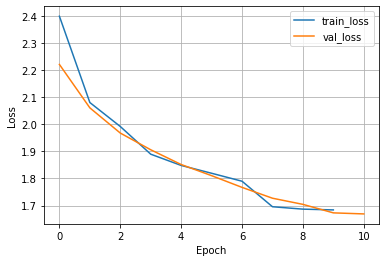

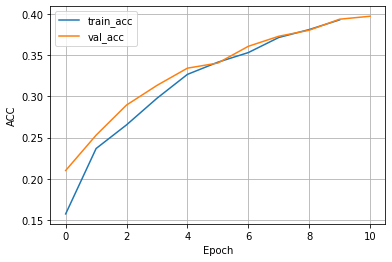

In [55]:
loss_metric_plot(trainer)

Cosine Annealing

In [52]:
class Cifar10ModelLightning(L.LightningModule):
    def __init__(self, model, learning_rate, lr_steps):
        super(Cifar10ModelLightning, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.criterion = torch.nn.CrossEntropyLoss()
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.save_hyperparameters(ignore=["model"])
        self.lr_steps = lr_steps

    def forward(self, x: torch.Tensor):
        """
        Forward computation of the model
        """
        return self.model(x)

    def _shared_step(self, batch):
        """
        Shared step for training and validation
        """
        features, label = batch
        logits = self(features)
        loss = self.criterion(logits, label)
        predictions = torch.argmax(logits, dim=1)
        return label, loss, predictions

    def training_step(self, batch, batch_idx):
        """
        Training Step loss and metric calculation
        """

        label, loss, predictions = self._shared_step(batch)
        self.log(name="train_loss", value=loss, prog_bar=True)
        # metric calculation
        self.train_acc(predictions, label)
        self.log(
            name="train_acc",
            value=self.train_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation Step loss and metric calculation
        """

        label, loss, predictions = self._shared_step(batch)
        self.log(name="val_loss", value=loss, prog_bar=True)
        # metric calculation
        self.test_acc(predictions, label)
        self.log(
            name="val_acc",
            value=self.test_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

    def test_step(self, batch, batch_idx):
        """
        Test step metric calculation
        """
        label, loss, predictions = self._shared_step(batch)
        # metric calculation
        self.test_acc(predictions, label)
        self.log(
            name="test_acc",
            value=self.test_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

    def configure_optimizers(
        self,
    ):
        """
        Optimizer config
        """
        optimizer = torch.optim.Adam(
            self.parameters(), lr=learning_rate, weight_decay=1e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.lr_steps
        )  

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",  # step means "batch" here, default: epoch   # New!
                "frequency": 1,  # default
            },
        }

In [81]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=True, mode="min")
device_monitor = DeviceStatsMonitor()
model_checkpoint = ModelCheckpoint(
    dirpath="./models",
    monitor="val_loss",
    mode="min",
    verbose=True,
    save_top_k=1,
)

In [82]:
# redefine epoch
epochs = 15

In [83]:
# lightning dataloder
dm = Cifar10DataModule(num_workers=5)
dm.setup("fit")
lr_steps = len(dm.train_dataloader())
dm.teardown("fit")


# base pytorch model
resnet_model = ResNetX(
    resnet_variant=model_parameters["resnet18"], img_channels=3, num_classes=10
).to(device)

# lightning wrapped model
lightning_resnet = Cifar10ModelLightning(
    model=resnet_model,
    learning_rate=suggested_lr,
    lr_steps=lr_steps,
)

# setting up the trainer module
trainer = L.Trainer(
    max_epochs=(epochs),
    accelerator="auto",
    devices="auto",
    enable_progress_bar=True,
    enable_model_summary=True,
    logger=CSVLogger(save_dir="./logs", name="Mnist_exp"),
    callbacks=[early_stopping, device_monitor, model_checkpoint],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [84]:
# fitting the model on training and test on validation data
trainer.fit(model=lightning_resnet, datamodule=dm)

Files already downloaded and verified
Files already downloaded and verified


/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNetX            | 11.2 M
1 | criterion | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |                                                                                                   …

Validation: |                                                                                                 …

Metric val_loss improved. New best score: 2.369
Epoch 0, global step 274: 'val_loss' reached 2.36933 (best 2.36933), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=0-step=274.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.746 >= min_delta = 0.0. New best score: 1.623
Epoch 1, global step 548: 'val_loss' reached 1.62288 (best 1.62288), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=1-step=548-v1.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.199 >= min_delta = 0.0. New best score: 1.424
Epoch 2, global step 822: 'val_loss' reached 1.42421 (best 1.42421), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=2-step=822.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.066 >= min_delta = 0.0. New best score: 1.358
Epoch 3, global step 1096: 'val_loss' reached 1.35849 (best 1.35849), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=3-step=1096.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 1.304
Epoch 4, global step 1370: 'val_loss' reached 1.30380 (best 1.30380), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=4-step=1370.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.279
Epoch 5, global step 1644: 'val_loss' reached 1.27899 (best 1.27899), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=5-step=1644.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 1.217
Epoch 6, global step 1918: 'val_loss' reached 1.21661 (best 1.21661), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=6-step=1918.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 7, global step 2192: 'val_loss' was not in top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.173
Epoch 8, global step 2466: 'val_loss' reached 1.17321 (best 1.17321), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=8-step=2466-v3.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.148
Epoch 9, global step 2740: 'val_loss' reached 1.14790 (best 1.14790), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=9-step=2740-v9.ckpt' as top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 1.107
Epoch 10, global step 3014: 'val_loss' reached 1.10743 (best 1.10743), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=10-step=3014.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 11, global step 3288: 'val_loss' was not in top 1


Validation: |                                                                                                 …

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 1.054
Epoch 12, global step 3562: 'val_loss' reached 1.05435 (best 1.05435), saving model to '/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=12-step=3562-v1.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 13, global step 3836: 'val_loss' was not in top 1


Validation: |                                                                                                 …

Epoch 14, global step 4110: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=15` reached.


In [85]:
# testing the metrics
val_acc = trainer.validate(datamodule=dm, ckpt_path="best")[0]["val_acc"]
test_acc = trainer.test(datamodule=dm, ckpt_path="best")[0]["test_acc"]
print(f" | Val Acc {val_acc*100:.2f}%" f" | Test Acc {test_acc*100:.2f}%")

Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=12-step=3562-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=12-step=3562-v1.ckpt


Validation: |                                                                                                 …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.6230666637420654     │
│         val_loss          │    1.0597244501113892     │
└───────────────────────────┴───────────────────────────┘

Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=12-step=3562-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch/models/epoch=12-step=3562-v1.ckpt


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.678600013256073     │
└───────────────────────────┴───────────────────────────┘

 | Val Acc 62.31% | Test Acc 67.86%


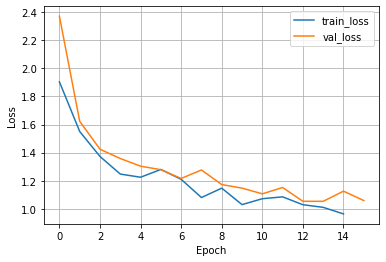

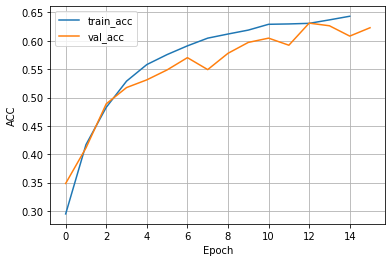

In [86]:
loss_metric_plot(trainer)

Misclassified Images

In [87]:
# loading the best model
path = trainer.checkpoint_callback.best_model_path

In [88]:
resnet_model = ResNetX(
    resnet_variant=model_parameters["resnet18"], img_channels=3, num_classes=10
).to(device)

lightning_model = Cifar10ModelLightning.load_from_checkpoint(
    path, model=resnet_model
)
dm = Cifar10DataModule()

In [196]:
def misclassified_images(model, device, dataloader):
    model.eval()
    dataloader.setup("test")
    features, targets, predictions = [], [], []

    with torch.no_grad():
        for data_batch, labels in dataloader.test_dataloader():
            data_batch, labels = data_batch.to(device), labels.to(device)

            for data, target in zip(data_batch, labels):
                data = data.unsqueeze(0)
                pred_logit = lightning_model(data)
                pred_label = torch.argmax(pred_logit, dim=1).squeeze()
                outcome = torch.equal(target, pred_label)

                if not outcome:
                    features.append(
                        data.detach().cpu().numpy().squeeze(0).transpose((1, 2, 0))
                    )
                    targets.append(target.detach().cpu().numpy().item())
                    predictions.append(pred_label.detach().cpu().numpy().item())

    return features, targets, predictions

In [197]:
mis_features, mis_targets, mis_predictions = misclassified_images(
    lightning_model, device, dm
)

In [198]:
def show_misclassified(mis_features: list, samples: int):
    if samples % 5 == 0:
        plt.figure(figsize=(10, 10))  # specifying the overall grid size
        for i in range(samples):
            plt.subplot(
                int(samples // 5),
                int(samples / (samples // 5)),
                i + 1,
            )  # the number of images in the grid is 5*5 (25)
            plt.imshow(
                mis_features[i], interpolation="nearest"
            )

        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


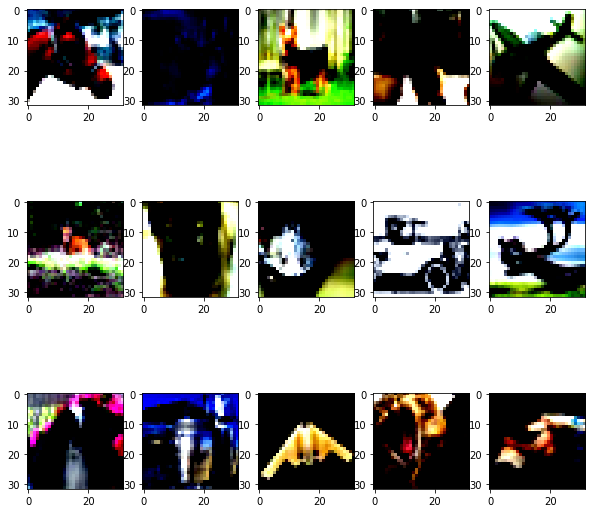

In [199]:
show_misclassified(mis_features, 15)

Application of GRAD CAM

In [200]:
# path = trainer.checkpoint_callback.best_model_path
# # trying to load the base model using weights saved in lightning
# resnet_model = ResNetX(
#     resnet_variant=model_parameters["resnet34"], img_channels=3, num_classes=10
# ).to(device)
# checkpoint = torch.load(path)
# resnet_model.load_state_dict(checkpoint["state_dict"],strict=False)

In [201]:
resnet_model = ResNetX(
    resnet_variant=model_parameters["resnet18"], img_channels=3, num_classes=10
).to(device)

lightning_model = Cifar10ModelLightning.load_from_checkpoint(path, model=resnet_model)

In [202]:
from pytorch_grad_cam import GradCAM, HiResCAM
from pytorch_grad_cam.utils.image import preprocess_image, show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


In [235]:
target_layers = [resnet_model.layer3]

In [236]:
input_image = mis_features[1]
print(input_image.shape)
label = mis_targets[1]
print(label)

(32, 32, 3)
4


In [237]:
import cv2

In [238]:
inv_normalize = transforms.Normalize(
    mean=[-0.50 / 0.23, -0.50 / 0.23, -0.50 / 0.23], std=[1 / 0.23, 1 / 0.23, 1 / 0.23]
)

In [239]:
def gardcam_imageprep(img):
    if not isinstance(img, np.ndarray):
        img = np.array(img)

    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(
        img, mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]
    )

    return img, input_tensor


def grad_cam_trainer(model, target_layers, image, input_tensor, prediction_label):
    # model targets
    targets = [ClassifierOutputTarget(prediction_label)]
    # grad cam
    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
        cam_image = show_cam_on_image(image, grayscale_cams[0, :], use_rgb=True)

    #  image display
    cam = np.uint8(255 * grayscale_cams[0, :])
    cam = cv2.merge([cam, cam, cam])
    cam_images = np.hstack((np.uint8(255 * image), cam, cam_image))

    return cam_images

In [240]:
img, input_tensor = gardcam_imageprep(input_image)
op = grad_cam_trainer(
    resnet_model, target_layers, img, input_tensor, label
)

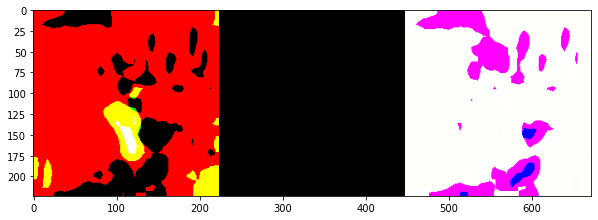

In [241]:
plt.figure(figsize=(10, 9))
plt.imshow(op)